# Introduction

Hyperspectral data due to their very fine spectral resolutions make it possible to identify as well as quantify some of the key biochemical parameters such as leaf pigments, leaf water and dry matter content. Apart from standard spectral indices methods, there are some other interesting methods such as continuum removal and derivative spectra, which make use of entire or specific part of the spectrum to relate reflectance to a parameter of interest.

Remind yourself, by looking at the standard vegetation spectrum below which shows different wavelength regions sensitive to different leaf level parameters. 

![Spectral Curves](figures/spectral_curve.png)

In the first part of this practical we will be focussing on leaf chlorophyll content. These analyses above will be done using spectra simulated using vegetation radiative transfer model called PROSAIL (Jacquemoud et al., 2009).


## Running Notebook

The notebook has been run and saved with the outputs so you can see what the outputs should be and so the notebook and be browsed online without having to run the notebook for it to make sense. 

If you are running the notebook for yourself it is recommended that you clear the existing outputs which can be done by running one of the following options depending on what system you are using:

**Jupyter-lab**:

> \> _Edit_ \> _'Clear All Outputs'_

**Jupyter-notebook**:

> \> _Cell_ \> _'All Outputs'_ \> _Clear_



# 1. Import Modules

In [1]:
import os

import matplotlib
import matplotlib.pyplot as plt
import numpy
import pandas

# Import pysptools module for spectral analysis.
# (https://pysptools.sourceforge.io)
import pysptools.spectro
import scipy.interpolate

# Import scipy modules for signal processing
# and interpolation
import scipy.signal

# Import tqdm module for progress bars.
import tqdm.notebook as tqdm

# Import the matplotlib plotting module and set it to work within
# a notebook environment.
%matplotlib inline

# 2. Plotting Spectra

For the first task, we will just use Python to plot the spectral in the input file PROSAILsimulated_Spectra_Chlorophyll.txt. Read this code and try to understand what it is doing and then run it.


In [2]:
# Read the input data
in_spectral_file = "PROSAILsimulated_Spectra_Chlorophyll.txt"
in_spectral_data = pandas.read_csv(in_spectral_file, sep="\t")
in_spectral_data

,WL,Chl 5,Chl 10,Chl 15,Chl 20,Chl 25,Chl 30,Chl 35,Chl 40,Chl 45,Chl 50,Chl 55,Chl 60
0,400,5.0,3.6,2.9,2.5,2.3,2.1,2.0,2.0,1.9,1.9,1.9,1.9
1,410,5.7,3.9,3.1,2.6,2.3,2.1,2.0,1.9,1.9,1.9,1.9,1.8
2,420,7.1,4.6,3.4,2.8,2.4,2.2,2.1,2.0,1.9,1.9,1.8,1.8
3,430,8.2,5.1,3.7,2.9,2.5,2.3,2.1,2.0,1.9,1.9,1.8,1.8
4,440,9.4,5.8,4.1,3.3,2.7,2.4,2.2,2.1,2.0,1.9,1.9,1.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,2360,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0
197,2370,7.8,7.8,7.8,7.8,7.8,7.8,7.8,7.8,7.8,7.8,7.8,7.8
198,2380,7.6,7.6,7.6,7.6,7.6,7.6,7.6,7.6,7.6,7.6,7.6,7.6
199,2390,7.4,7.4,7.4,7.4,7.4,7.4,7.4,7.4,7.4,7.4,7.4,7.4


In [3]:
# Get column names
colnames = list(in_spectral_data.columns)
colnames.remove("WL")
colnames

['Chl 5',
 'Chl 10',
 'Chl 15',
 'Chl 20',
 'Chl 25',
 'Chl 30',
 'Chl 35',
 'Chl 40',
 'Chl 45',
 'Chl 50',
 'Chl 55',
 'Chl 60']

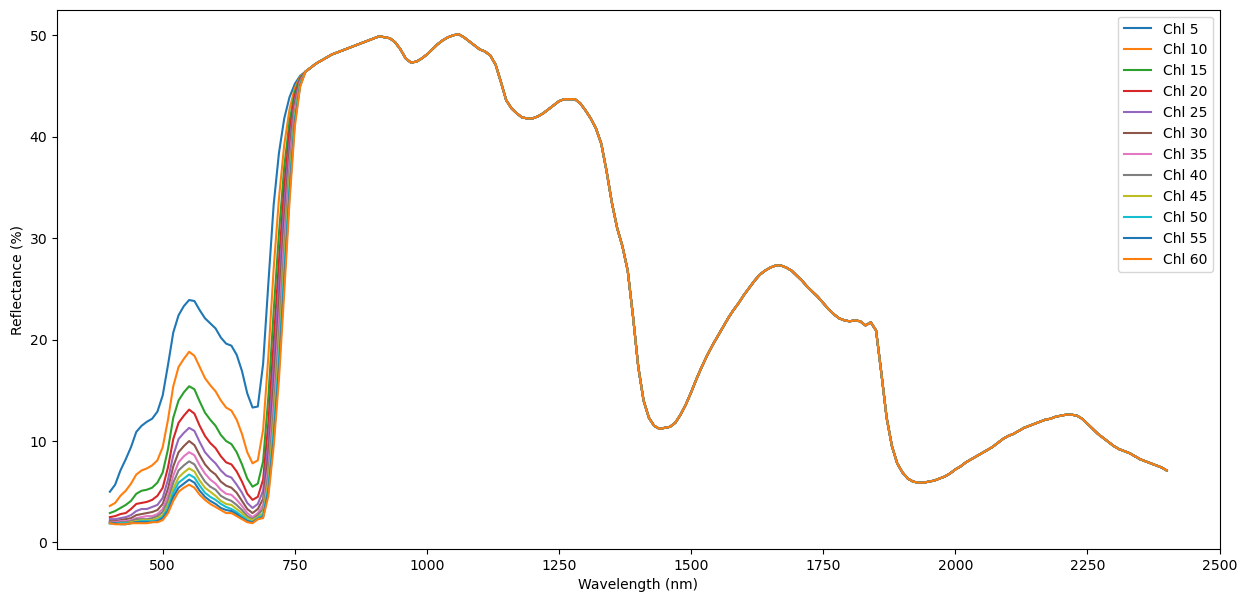

In [4]:
plt.figure(1, figsize=(15, 7))

for col in colnames:
    plt.plot(in_spectral_data["WL"].values, in_spectral_data[col].values, label=col)

plt.ylabel("Reflectance (%)")
plt.xlabel("Wavelength (nm)")
plt.legend()

# 3. Continuum Removal

Continuum removal analysis characterises the absorption features in a spectra. It involves the normalisation of spectra by fitting a straight line between two peaks, thus removing the overall convex shape of the spectra. This allows quantification of absorption area, against a common baseline.

In this case, we are fitting this baseline between 530 to 750 nm. This part of the spectrum is dominated by chlorophyll absorption. As a first step to most of the hyperspectral analysis, the spectrum is smoothed in order to get rid of noise. We use Savitzy-Golay filter from scipy library. In this particular dataset, as spectra are simulated using a PROSAIL model, there are no noisy features, but it is important to use smoothed spectra when using real datasets.

Look at the code below and try to understand the different steps

In [5]:
# Get the wavelengths as list
wvls = in_spectral_data["WL"].tolist()
print(wvls)

[400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640, 650, 660, 670, 680, 690, 700, 710, 720, 730, 740, 750, 760, 770, 780, 790, 800, 810, 820, 830, 840, 850, 860, 870, 880, 890, 900, 910, 920, 930, 940, 950, 960, 970, 980, 990, 1000, 1010, 1020, 1030, 1040, 1050, 1060, 1070, 1080, 1090, 1100, 1110, 1120, 1130, 1140, 1150, 1160, 1170, 1180, 1190, 1200, 1210, 1220, 1230, 1240, 1250, 1260, 1270, 1280, 1290, 1300, 1310, 1320, 1330, 1340, 1350, 1360, 1370, 1380, 1390, 1400, 1410, 1420, 1430, 1440, 1450, 1460, 1470, 1480, 1490, 1500, 1510, 1520, 1530, 1540, 1550, 1560, 1570, 1580, 1590, 1600, 1610, 1620, 1630, 1640, 1650, 1660, 1670, 1680, 1690, 1700, 1710, 1720, 1730, 1740, 1750, 1760, 1770, 1780, 1790, 1800, 1810, 1820, 1830, 1840, 1850, 1860, 1870, 1880, 1890, 1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090, 2100, 2110, 2120, 2130, 2140, 2150, 216

In [6]:
# Create a pandas DataFrame to store results of the analysis
cont_rmv_results = pandas.DataFrame(
    columns=[
        "chl_content",
        "abs_depth",
        "area",
        "cslope",
        "FWHM_x1",
        "FWHM_x2",
        "FWHM_y1",
        "FWHM_y2",
        "FWHM_delta",
    ]
)
cont_rmv_results

,chl_content,abs_depth,area,cslope,FWHM_x1,FWHM_x2,FWHM_y1,FWHM_y2,FWHM_delta


In [7]:
# Output directory for the results of this analysis
out_dir = "prosail_chl_results"
if not os.path.exists(out_dir):
    os.mkdir(out_dir)

In [8]:
# Parameters for smoothing the spectra. Window size and order of the fitted polynomial
window_len = 5
order = 3

# The wavelength region in the spectra used for the analysis (i.e., 530 - 750 nm)
start_wvl = 530
end_wvl = 750

# Loop through each of the modelled spectra and perform the analysis.
# The tqdm module is an easy why to produce a progress bar to feedback to the user
j = 0
for col in tqdm.tqdm(colnames):
    # Get the spectra for the model in the specified column
    spectra = in_spectral_data[col]
    # Rescale the spectra so range is 0-1 rather than 0-100.
    spectra_fract = spectra / 100

    # Smoothing spectra using savitzy-golay algorithm
    spectra_fract_smooth = scipy.signal.savgol_filter(spectra_fract, window_len, order)

    # Fit convex hull to wavelength region and calculate absorption feature related parameters
    spec_fea_chq = pysptools.spectro.FeaturesConvexHullQuotient(
        spectra_fract_smooth.tolist(),
        wvls,
        baseline=1,
        startContinuum=start_wvl,
        stopContinuum=end_wvl,
    )

    # Creating plots and save to the output dir
    col_out_name = col.lower().replace(" ", "_")
    spec_fea_chq.plot_convex_hull_quotient(out_dir, col_out_name)
    spec_fea_chq.plot(out_dir, col_out_name, feature="all")

    # Writing output parameters in the pandas dataframe
    spec_fea_chq_atts = spec_fea_chq.features[0]
    cont_rmv_results.at[j, "chl_content"] = col
    cont_rmv_results.at[j, "abs_depth"] = spec_fea_chq_atts["abs_depth"]
    cont_rmv_results.at[j, "area"] = spec_fea_chq_atts["area"]
    cont_rmv_results.at[j, "cslope"] = spec_fea_chq_atts["cslope"]
    cont_rmv_results.at[j, "FWHM_x1"] = spec_fea_chq_atts["FWHM_x"][0]
    cont_rmv_results.at[j, "FWHM_x2"] = spec_fea_chq_atts["FWHM_x"][1]
    cont_rmv_results.at[j, "FWHM_y1"] = spec_fea_chq_atts["FWHM_y"][0]
    cont_rmv_results.at[j, "FWHM_y2"] = spec_fea_chq_atts["FWHM_y"][1]
    cont_rmv_results.at[j, "FWHM_delta"] = spec_fea_chq_atts["FWHM_delta"]

    # Increment variable to write in the next row in the results dataframe
    j += 1


# Save the results dataframe to a CSV file
results_csv_file = os.path.join(out_dir, "chl_results_tbl.csv")
cont_rmv_results.to_csv(results_csv_file, index=False)

  0%|          | 0/12 [00:00<?, ?it/s]

In [9]:
# Show the populated dataframe
cont_rmv_results

,chl_content,abs_depth,area,cslope,FWHM_x1,FWHM_x2,FWHM_y1,FWHM_y2,FWHM_delta
0,Chl 5,0.356048,61.494273,0.00104,600,710,0.678024,0.678024,110
1,Chl 10,0.223341,84.183774,0.001263,590,710,0.611671,0.611671,120
2,Chl 15,0.164203,97.425071,0.001401,580,710,0.582102,0.582102,130
3,Chl 20,0.129156,107.123222,0.001491,580,720,0.564578,0.564578,140
4,Chl 25,0.109581,114.080815,0.00155,570,720,0.554791,0.554791,150
5,Chl 30,0.095551,119.808562,0.001593,570,720,0.547775,0.547775,150
6,Chl 35,0.084395,124.535901,0.001624,570,720,0.542198,0.542198,150
7,Chl 40,0.079197,128.30437,0.001645,570,720,0.539598,0.539598,150
8,Chl 45,0.074103,131.695536,0.001662,560,730,0.537052,0.537052,170
9,Chl 50,0.071346,134.478739,0.00167,560,730,0.535673,0.535673,170


Within the output directory (‘prosail_chl_results’) you will have a number of output files. chl_results_tbl.csv has the table of output metrics and can be opened in a spreadsheet application (e.g., Excel). What you should be able to see in this data is that as the chlorophyll content increases the area of the absorption feature increases while the absolute depth of the absorption feature decreases. This is because as the amount chlorophyll increases the reflectance around 550 nm (green peak) decreases (Check the reflectance plot for range of chlorophyll content above). Hence, leaves with very high chlorophyll content generally appear dark. This results in feature becoming wider in shape but shallower. This is shown in the figure below:

Text(0.5, 0, 'Chlorophyll Content (${\\mu}g$ cm² of leaf)')

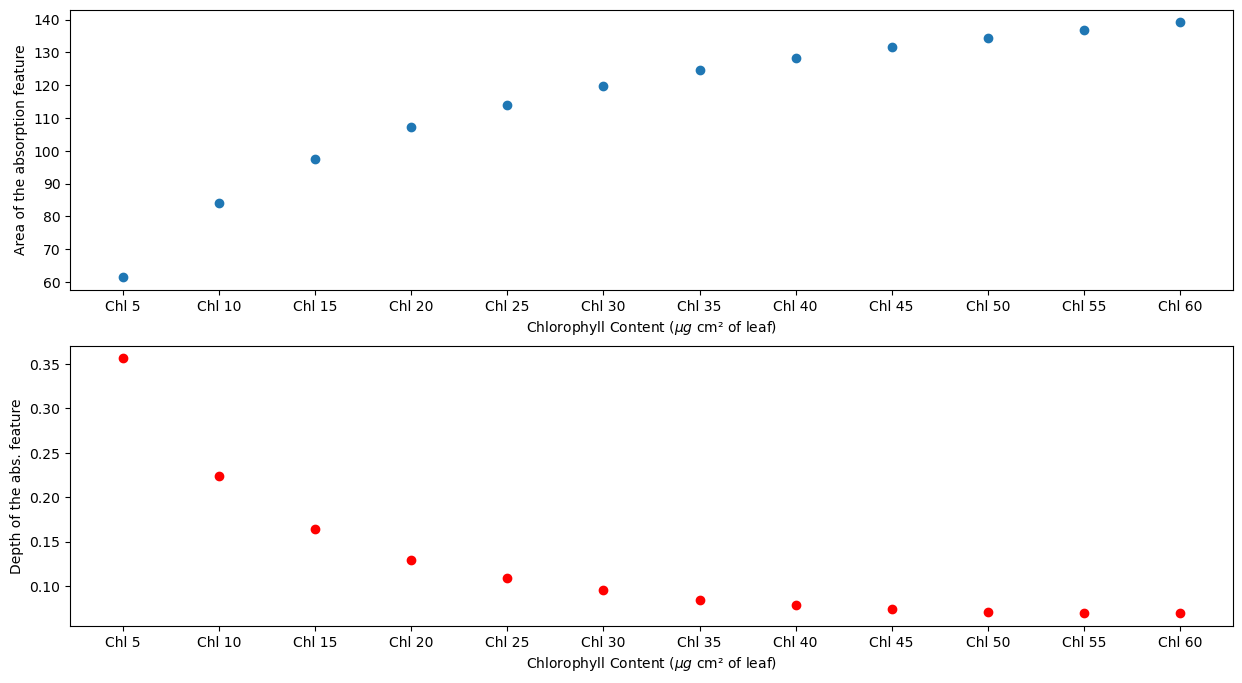

In [10]:
%matplotlib inline
# Create results plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))

ax1.scatter(cont_rmv_results["chl_content"].values, cont_rmv_results["area"].values)
ax1.set_ylabel("Area of the absorption feature")
ax1.set_xlabel("Chlorophyll Content (${\mu}g$ cm\N{SUPERSCRIPT TWO} of leaf)")

ax2.scatter(
    cont_rmv_results["chl_content"].values,
    cont_rmv_results["abs_depth"].values,
    color="r",
)
ax2.set_ylabel("Depth of the abs. feature")
ax2.set_xlabel("Chlorophyll Content (${\mu}g$ cm\N{SUPERSCRIPT TWO} of leaf)")

Open the output folder ‘prosail_chl_results’. It will contain two figures corresponding to each Chlorophyll content. Open up figures called 'chl_5.png' and 'chl_5_feature 1.png'.

![Spectral Curves](figures/chl_5.png)

chl_5.png: Demonstrates how the continuum removal works. As seen in the figure above, a straight baseline (or hull) is fitted between two wavelengths 530 and 750nm. Then for each point on the spectrum, depth from this line is calculated. The green line is the normalised continuum removed spectrum (CRS). 

![Spectral Curves](figures/chl_5_feature_1.png)

chl_5_feature 1.png: Shows the absorption feature with respect to the new baseline (hull). The red line marks the maximum depth of the feature. The ‘area’ corresponds to the total area enclosed by the feature under the hull. FWHM line marks two wavelengths marking the width of the feature.


# 4. Derivative Analysis

The first derivative of a spectra is given using the equation below:
    
$$
  \frac{ds}{d\lambda_{i}} = \frac{s(\lambda_{j}) - s(\lambda_{i}))}{\Delta\lambda}
$$

Where, $s(\lambda_{j})$ and $s(\lambda_{i})$ denote the reflectance in two subsequent wavelengths and $j > i$. In simple terms, first derivative spectrum is the slope or gradient of the reflectance spectrum. It reduces sensitivity of the reflectance to variations in the illumination condition, soil and background reflectance. The derivative spectra have been found to be useful in determining the location of the red-edge, which corresponds to the position where amplitude of the derivative spectra is maximum (Blackburn, 2006). 


The following code estimates the red-edge location for our simulated vegetation spectra.

In [11]:
wvls_arr = numpy.asarray(wvls)

# Results dataframe
results_spectra = pandas.DataFrame(columns=colnames)
wvl_middle = wvls_arr[1:] + (wvls_arr[1:] - wvls_arr[:-1]) / 2
results_spectra["wvl"] = wvl_middle
results_spectra

,Chl 5,Chl 10,Chl 15,Chl 20,Chl 25,Chl 30,Chl 35,Chl 40,Chl 45,Chl 50,Chl 55,Chl 60,wvl
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,415.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,425.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,435.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,445.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,455.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2365.0
196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2375.0
197,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2385.0
198,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2395.0


  0%|          | 0/12 [00:00<?, ?it/s]

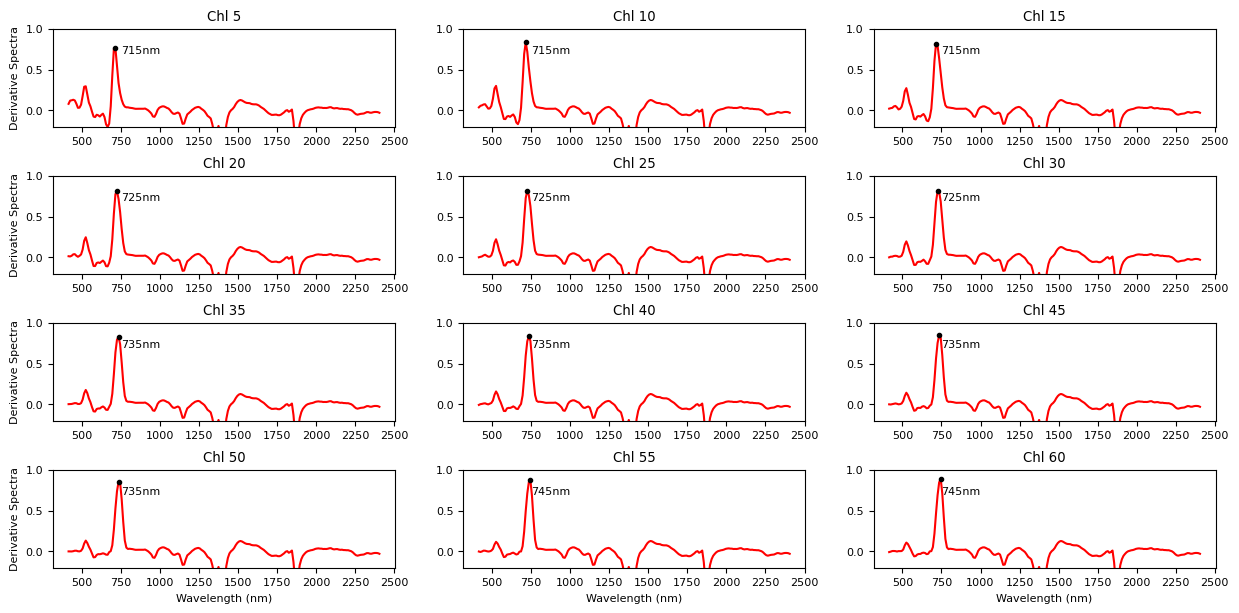

In [12]:
%matplotlib inline
# Parameters for smoothing the spectra. Window size and order of the fitted polynomial
window_len = 5
order = 3

plt.figure(1, figsize=(15, 7))
plt.rcParams.update({"font.size": 8})
plt.subplots_adjust(hspace=0.5)  # increases the space between the two plots
j = 1
for col in tqdm.tqdm(colnames):
    # Smoothing spectra using savitzy-golay algorithm
    spectra_smooth = scipy.signal.savgol_filter(
        in_spectral_data[col], window_len, order
    )

    # Calculate the derivative (gradiant)
    results_spectra[col] = (spectra_smooth[1:] - spectra_smooth[:-1]) / (
        wvls[1:] - wvls_arr[:-1]
    )
    # Find the index of the maximum (highest) derivative
    maxValueIdx = results_spectra[col].idxmax(axis=0)

    plt.subplot(4, 3, j)
    plt.plot(wvl_middle, results_spectra[col].values, "r")
    wvl_abs = results_spectra.at[maxValueIdx, "wvl"]
    plt.plot(wvl_abs, results_spectra[col].max(), ".k")
    plt.text(750, 0.7, str(int(wvl_abs)) + "nm")
    plt.ylim(-0.2, 1)
    plt.title(col)

    if j >= 10:
        plt.xlabel("Wavelength (nm)")
    if (j == 1) or (j == 4) or (j == 7) or (j == 10):
        plt.ylabel("Derivative Spectra")
    j += 1

# Save the results dataframe to a CSV file
derived_spec_out_file = os.path.join(out_dir, "prosail_derivative_spectra_tbl.csv")
results_spectra.to_csv(derived_spec_out_file, index=False)

Within the plot above with the wavelength marks the maximum first derivative.

The results in the plot basically shows that with an increase in the leaf chlorophyll content, the position of the red-edge shifts towards right. This also corresponds to our previous analysis with the continuum removal spectra where we saw that with increase in leaf chlorophyll content, the absorption feature widens. 

The derivative analysis could be further be extended by second, third and fourth derivative and so on…


In [13]:
# Show the populated dataframe
results_spectra

,Chl 5,Chl 10,Chl 15,Chl 20,Chl 25,Chl 30,Chl 35,Chl 40,Chl 45,Chl 50,Chl 55,Chl 60,wvl
0,0.080000,0.037143,0.021429,0.014286,0.001429,0.000714,0.002857,-0.006429,0.000714,-2.220446e-17,-0.001429,-0.008571,415.0
1,0.120000,0.055714,0.027143,0.011429,0.007143,0.008571,0.004286,0.002857,-0.001429,6.661338e-17,-0.007143,-0.002857,425.0
2,0.123714,0.062000,0.030857,0.020286,0.011714,0.009143,0.005143,0.006000,0.002571,-8.571429e-04,-0.000857,0.004286,435.0
3,0.130286,0.072571,0.048571,0.037429,0.024286,0.016857,0.010000,0.010857,0.007429,2.571429e-03,0.009143,0.004857,445.0
4,0.121714,0.075429,0.054571,0.039714,0.032286,0.019714,0.015714,0.013143,0.011714,8.285714e-03,0.008286,0.003429,455.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,-0.022571,-0.022571,-0.022571,-0.022571,-0.022571,-0.022571,-0.022571,-0.022571,-0.022571,-2.257143e-02,-0.022571,-0.022571,2365.0
196,-0.019143,-0.019143,-0.019143,-0.019143,-0.019143,-0.019143,-0.019143,-0.019143,-0.019143,-1.914286e-02,-0.019143,-0.019143,2375.0
197,-0.019143,-0.019143,-0.019143,-0.019143,-0.019143,-0.019143,-0.019143,-0.019143,-0.019143,-1.914286e-02,-0.019143,-0.019143,2385.0
198,-0.021429,-0.021429,-0.021429,-0.021429,-0.021429,-0.021429,-0.021429,-0.021429,-0.021429,-2.142857e-02,-0.021429,-0.021429,2395.0


# 5. Applying this to Real Data 

The previous two examples were performed using modelled data. Now let’s try applying these methods to some real data. These data are within the FENIX_Spectra_Species.txt text file and contain average canopy spectra for three species:

 * Sanguisorba officinalis (SO)
 * Juncus acutiflorus (JA)
 * Carex acuta (CA)

The bar plot below shows actual measurements of leaf chlorophyll content in these three species.

![leaf chlorophyll content](figures/fenix_chl_content.png)

Average leaf chlorophyll content for SO, CA and JA. Number in the parenthesis show number of leaf samples analysed.

This analysis can be performed using the code below, which will produce similar outputs to the analysis with the modelled spectral. You can run the following code with the results outputted to the fenix_results directory:



In [14]:
# Check output directory exists
out_fenix_dir = "fenix_results"
if not os.path.exists(out_fenix_dir):
    os.mkdir(out_fenix_dir)

In [15]:
# Define the path to the input spectra file
in_spectral_file = "FENIX_Spectra_Species.txt"

# Read the spectra into a pandas dataframe
in_spectral_data = pandas.read_csv(in_spectral_file, sep="\t")

# Get the wavelengths as list
wvls = in_spectral_data["WL"].tolist()

# Get column names, i.e., each modelled spectra is a different column
colnames = list(in_spectral_data.columns)
# Remove the wavelengths column from the list of column names as it is not a spectra
colnames.remove("WL")

In [16]:
# Create a pandas DataFrame to store results of the analysis
results_fenix = pandas.DataFrame(
    columns=[
        "species",
        "abs_depth",
        "area",
        "cslope",
        "FWHM_x1",
        "FWHM_x2",
        "FWHM_y1",
        "FWHM_y2",
        "FWHM_delta",
    ]
)
results_fenix

,species,abs_depth,area,cslope,FWHM_x1,FWHM_x2,FWHM_y1,FWHM_y2,FWHM_delta


In [17]:
# Parameters for smoothing the spectra. Window size and order of the fitted polynomial
window_len = 5
order = 3

# The wavelength region in the spectra used for the analysis (i.e., 530 - 750 nm)
start_wvl = 530
end_wvl = 750

# Loop through each of the modelled spectra and perform the analysis.
# The tqdm module is an easy why to produce a progress bar to feedback to the user
j = 0
for col in tqdm.tqdm(colnames):
    # Get the spectra for the model in the specified column
    spectra = in_spectral_data[col]
    # Rescale the spectra so range is 0-1 rather than 0-100.
    spectra_fract = spectra / 100

    # Smoothing spectra using savitzy-golay algorithm
    spectra_fract_smooth = scipy.signal.savgol_filter(spectra_fract, window_len, order)

    # Fit convex hull to wavelength region and calculate absorption feature related parameters
    spec_fea_chq = pysptools.spectro.FeaturesConvexHullQuotient(
        spectra_fract_smooth.tolist(),
        wvls,
        baseline=1,
        startContinuum=start_wvl,
        stopContinuum=end_wvl,
    )

    # Creating plots and save to the output dir
    col_out_name = col.lower().replace(" ", "_")
    spec_fea_chq.plot_convex_hull_quotient(out_dir, col_out_name)
    spec_fea_chq.plot(out_dir, col_out_name, feature="all")

    # Writing output parameters in the pandas dataframe
    spec_fea_chq_atts = spec_fea_chq.features[0]
    results_fenix.at[j, "species"] = col
    results_fenix.at[j, "abs_depth"] = spec_fea_chq_atts["abs_depth"]
    results_fenix.at[j, "area"] = spec_fea_chq_atts["area"]
    results_fenix.at[j, "cslope"] = spec_fea_chq_atts["cslope"]
    results_fenix.at[j, "FWHM_x1"] = spec_fea_chq_atts["FWHM_x"][0]
    results_fenix.at[j, "FWHM_x2"] = spec_fea_chq_atts["FWHM_x"][1]
    results_fenix.at[j, "FWHM_y1"] = spec_fea_chq_atts["FWHM_y"][0]
    results_fenix.at[j, "FWHM_y2"] = spec_fea_chq_atts["FWHM_y"][1]
    results_fenix.at[j, "FWHM_delta"] = spec_fea_chq_atts["FWHM_delta"]

    # Increment variable to write in the next row in the results dataframe
    j += 1


# Save the results dataframe to a CSV file
results_csv_file = os.path.join(out_fenix_dir, "fenix_chl_results_tbl.csv")
results_fenix.to_csv(results_csv_file, index=False)
results_fenix

  0%|          | 0/3 [00:00<?, ?it/s]

,species,abs_depth,area,cslope,FWHM_x1,FWHM_x2,FWHM_y1,FWHM_y2,FWHM_delta
0,SO,0.062497,132.992707,0.002183,561.72998,713.190002,0.531248,0.531248,151.460022
1,JA,0.066316,131.70746,0.001367,561.72998,713.190002,0.533158,0.533158,151.460022
2,CA,0.066707,129.602638,0.001582,565.150024,713.190002,0.533353,0.533353,148.039978



The higher area of chlorophyll absorption and lower depth for SO compared to JA and CA correspond to its higher chlorophyll content. The result indicates that it maybe possible to separate different areas dominated by CA and JA as against SO in airborne hyperspectral data as there is clear separation in terms of their reflectance in the chlorophyll absorption region of the spectrum.

It is interesting to note that although average chlorophyll content of CA is very close to that of SO, it seems that the area of the absorption feature plot indicates that CA had lowest chlorophyll content amongst the three species being compared.

This can be explained considering few more limitations of hyperspectral data (more appropriately remote sensing itself) for monitoring leaf level biophysical/chemical parameters.

Vegetation reflectance spectrum has a distinct shape as shown in the first figure in the document, but several biophysical/parameters as well as viewing and solar illumination conditions regulate same parts of the spectrum. For example, visible part of the spectrum is strongly affected by leaf inclination and orientation as well as leaf area index (Punalekar et al., 2016). Collectively, the sensitivity of the spectrum becomes very complex and difficult to interpret independently for each parameter independently. Thus, in fact distinction of SO from CA and JA is not only a result of its higher chlorophyll content but also differences in terms of LAI, leaf angles, leaf dry matter content, etc (Punalekar et al. 2016). Whereas, reflectance as well as biophysical/chemical properties of CA and JA are more similar to each other.

These complex issues are tackled by either developing robust statistical models by building representative datasets for model calibration or by incorporation of physically based modelling approaches.


Text(0.5, 0, 'Species')

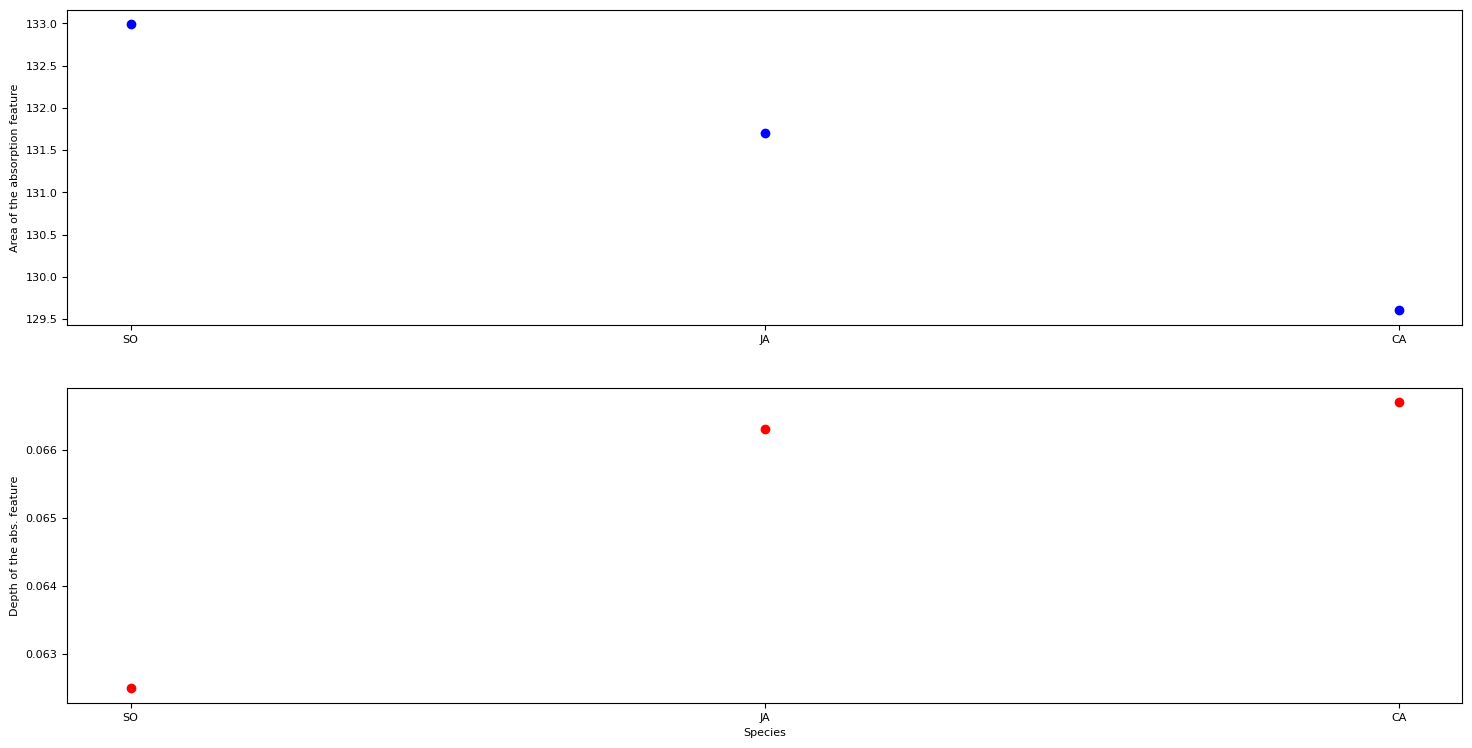

In [18]:
%matplotlib inline

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 9))

ax1.scatter(results_fenix["species"].values, results_fenix["area"].values, color="b")
ax1.set_ylabel("Area of the absorption feature")

ax2.scatter(
    results_fenix["species"].values, results_fenix["abs_depth"].values, color="r"
)
ax2.set_ylabel("Depth of the abs. feature")
ax2.set_xlabel("Species")

# 6. Spectral Resampling

A common use of in hyperspectral data, whether very high spectral resolution field spectra or from airborne or spaceborne instruments is to inform the interpretation of multispectral data (e.g., Sentinel-2, Landsat etc.). Part of such analysis requires that the hyperspectral spectra are resampled to match the multispectral sensor response. The sensor response is represented by sensor response functions, which for a given wavelength represent how sensitive the sensor is to that wavelength (i.e., how much of the energy hitting the sensor will be recorded). The sensor response functions for sentinel-2 are shown below and are within the file ‘S2A_spectral_response.csv’. 

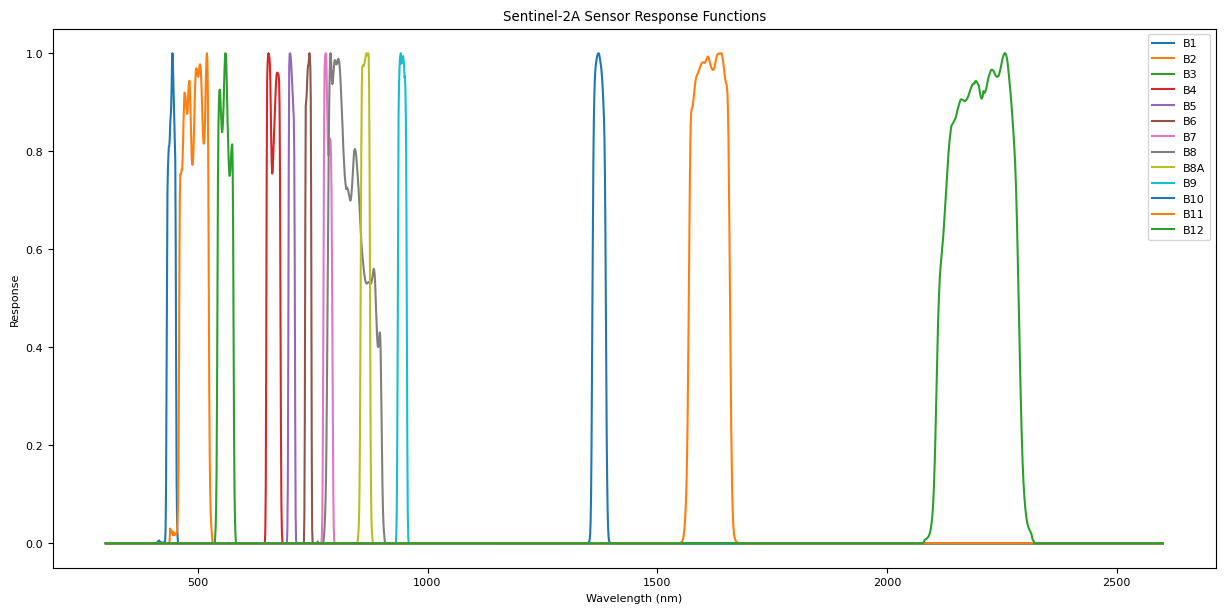

In [19]:
%matplotlib inline

s2_response_funcs_file = "S2A_spectral_response.csv"
s2_response_funcs_data = pandas.read_csv(s2_response_funcs_file, sep=",")

# Get column names
colnames = list(s2_response_funcs_data.columns)
colnames.remove("SR_WL")


plt.figure(1, figsize=(15, 7))
for col in colnames:
    col_short = col.replace("S2A_SR_AV_", "")
    plt.plot(
        s2_response_funcs_data["SR_WL"], s2_response_funcs_data[col], label=col_short
    )

plt.title("Sentinel-2A Sensor Response Functions")
plt.ylabel("Response")
plt.xlabel("Wavelength (nm)")
plt.legend()

To resample the hyperspectral spectra using the Sentinel-2 sensor response functions, you will need to calculate the weighted average of the reflectance in the hyperspectral spectra weighted by the sensor response function.

This analysis is undertaken below and outputs the plot below and the ‘PROSAILsimulated_Spectra_Chlorophyll_Sen2.csv’ file with the resampled spectra which will be used for the following analysis.


In [20]:
# Read the data in
s2_response_funcs_file = "S2A_spectral_response.csv"
s2_response_funcs_data = pandas.read_csv(s2_response_funcs_file, sep=",")

s2_response_funcs_data = s2_response_funcs_data[
    (s2_response_funcs_data.SR_WL >= 400) & (s2_response_funcs_data.SR_WL <= 2400)
]
s2_response_funcs_wl = s2_response_funcs_data["SR_WL"].values
s2_bandnames = list(s2_response_funcs_data.columns)
s2_bandnames.remove("SR_WL")


s2_wavelengths_file = "S2_wavebands.csv"
s2_wavelengths_data = pandas.read_csv(s2_wavelengths_file, sep=",")

in_spectral_file = "PROSAILsimulated_Spectra_Chlorophyll.txt"
in_spectral_data = pandas.read_csv(in_spectral_file, sep="\t")


s2_chl_refl_data = pandas.DataFrame()
s2_chl_refl_data["WL"] = s2_wavelengths_data["Centre Wavelength"].values


# Get column names
colnames = list(in_spectral_data.columns)
colnames.remove("WL")

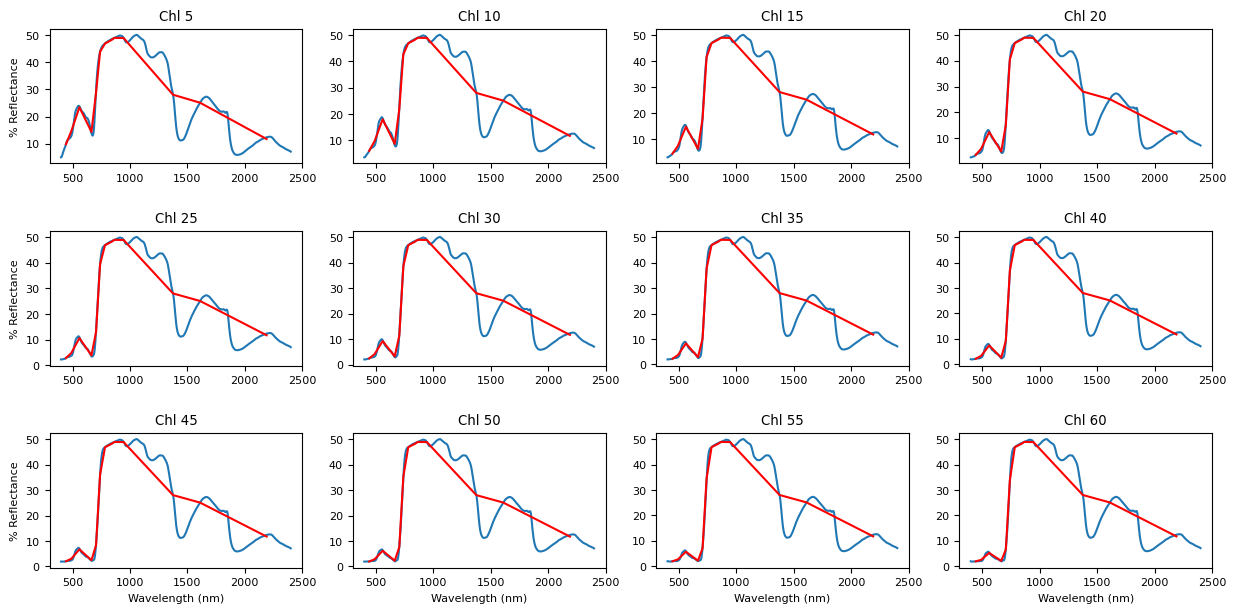

In [21]:
%matplotlib inline

i = 1
plt.figure(1, figsize=(15, 7))
for col in colnames:
    # Interpolation to match the band centres of hyperspectral data with the S2 spectral response function
    ft = scipy.interpolate.interp1d(
        in_spectral_data["WL"].values, in_spectral_data[col].values, kind="cubic"
    )
    s2_data_interp = ft(s2_response_funcs_wl)

    plt.subplot(3, 4, i)
    plt.plot(s2_response_funcs_wl, s2_data_interp)

    if i > 8:
        plt.xlabel("Wavelength (nm)")

    if (i == 1) or (i == 5) or (i == 9):
        plt.ylabel("% Reflectance")

    j = 0
    for bandname in s2_bandnames:
        s2_data_interp_band_resp = (
            s2_data_interp * s2_response_funcs_data[bandname].values
        )
        sum_resp_func = sum(s2_response_funcs_data[bandname].values)
        sum_band_spec = sum(s2_data_interp_band_resp)
        s2_chl_refl_data.at[j, col] = sum_band_spec / sum_resp_func

        j += 1
    i += 1
    plt.plot(
        s2_wavelengths_data["Centre Wavelength"].values,
        s2_chl_refl_data[col].values,
        color="red",
    )
    plt.title(col)

plt.subplots_adjust(hspace=0.5)  # increases the space between the two plots

In [22]:
out_resmpl_dir = "resampled_sen2_spec"
if not os.path.exists(out_resmpl_dir):
    os.mkdir(out_resmpl_dir)

out_chl_sen2_file = os.path.join(
    out_resmpl_dir, "PROSAILsimulated_Spectra_Chlorophyll_Sen2.csv"
)
s2_chl_refl_data.to_csv(out_chl_sen2_file, sep=",", index=False)

# 7. Is Chlorophyll Concentration Detectable in Sentinel-2?

## 7.1 Continuum Removal

Using the PROSAIL chlorophyll spectra resampled using the Sentinel-2 sensor response functions, we can now test whether Sentinel-2 is sensitive to chlorophyll concentration. Using the code from earlier as a base the code below undertakes this analsys with the outputs written to the prosail_s2_chl_results directory.

In [23]:
# Create the output directory
out_s2_chl_dir = "prosail_s2_chl_results"
if not os.path.exists(out_s2_chl_dir):
    os.mkdir(out_s2_chl_dir)

In [24]:
# Get the wavelengths as list
wvls = s2_chl_refl_data["WL"].tolist()
print(wvls)

[443, 490, 560, 665, 705, 740, 783, 842, 865, 945, 1375, 1610, 2190]


In [25]:
# Get column names, i.e., each modelled spectra is a different column
colnames = list(s2_chl_refl_data.columns)
# Remove the wavelengths column from the list of column names as it is not a spectra
colnames.remove("WL")

In [26]:
# Create a pandas DataFrame to store results of the analysis
s2_chl_results = pandas.DataFrame(
    columns=[
        "chl_content",
        "abs_depth",
        "area",
        "cslope",
        "FWHM_x1",
        "FWHM_x2",
        "FWHM_y1",
        "FWHM_y2",
        "FWHM_delta",
    ]
)
s2_chl_results

,chl_content,abs_depth,area,cslope,FWHM_x1,FWHM_x2,FWHM_y1,FWHM_y2,FWHM_delta


In [27]:
# Parameters for smoothing the spectra. Window size and order of the fitted polynomial
window_len = 5
order = 3

# The wavelength region in the spectra used for the analysis (i.e., 530 - 750 nm)
start_wvl = 530
end_wvl = 750

# Loop through each of the modelled spectra and perform the analysis.
# The tqdm module is an easy why to produce a progress bar to feedback to the user
j = 0
for col in tqdm.tqdm(colnames):
    # Get the spectra for the model in the specified column
    spectra = s2_chl_refl_data[col]
    # Rescale the spectra so range is 0-1 rather than 0-100.
    spectra_fract = spectra / 100

    # Smoothing spectra using savitzy-golay algorithm
    spectra_fract_smooth = scipy.signal.savgol_filter(spectra_fract, window_len, order)

    # Fit convex hull to wavelength region and calculate absorption feature related parameters
    spec_fea_chq = pysptools.spectro.FeaturesConvexHullQuotient(
        spectra_fract_smooth.tolist(),
        wvls,
        baseline=1,
        startContinuum=start_wvl,
        stopContinuum=end_wvl,
    )

    # Creating plots and save to the output dir
    col_out_name = col.lower().replace(" ", "_")
    spec_fea_chq.plot_convex_hull_quotient(out_s2_chl_dir, col_out_name)
    spec_fea_chq.plot(out_s2_chl_dir, col_out_name, feature="all")

    # Writing output parameters in the pandas dataframe
    spec_fea_chq_atts = spec_fea_chq.features[0]
    s2_chl_results.at[j, "chl_content"] = col
    s2_chl_results.at[j, "abs_depth"] = spec_fea_chq_atts["abs_depth"]
    s2_chl_results.at[j, "area"] = spec_fea_chq_atts["area"]
    s2_chl_results.at[j, "cslope"] = spec_fea_chq_atts["cslope"]
    s2_chl_results.at[j, "FWHM_x1"] = spec_fea_chq_atts["FWHM_x"][0]
    s2_chl_results.at[j, "FWHM_x2"] = spec_fea_chq_atts["FWHM_x"][1]
    s2_chl_results.at[j, "FWHM_y1"] = spec_fea_chq_atts["FWHM_y"][0]
    s2_chl_results.at[j, "FWHM_y2"] = spec_fea_chq_atts["FWHM_y"][1]
    s2_chl_results.at[j, "FWHM_delta"] = spec_fea_chq_atts["FWHM_delta"]

    # Increment variable to write in the next row in the results dataframe
    j += 1

# Save the results dataframe to a CSV file
results_csv_file = os.path.join(out_s2_chl_dir, "s2_chl_results_tbl.csv")
s2_chl_results.to_csv(results_csv_file, index=False)

  0%|          | 0/12 [00:00<?, ?it/s]

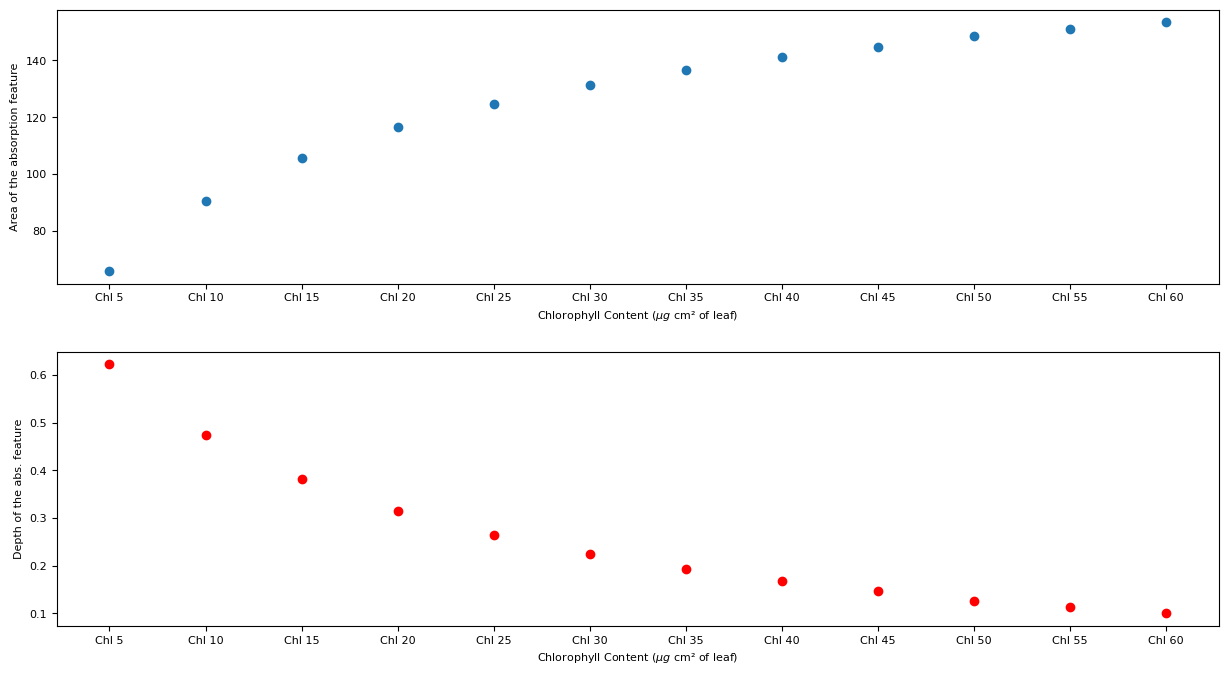

In [28]:
%matplotlib inline

# Create results plot
plt.figure(1, figsize=(15, 8))
plt.rcParams.update({"font.size": 8})
plt.subplot(2, 1, 1)
plt.scatter(s2_chl_results["chl_content"].values, s2_chl_results["area"].values)
plt.ylabel("Area of the absorption feature")
plt.xlabel("Chlorophyll Content (${\mu}g$ cm\N{SUPERSCRIPT TWO} of leaf)")

plt.subplot(2, 1, 2)
plt.scatter(
    s2_chl_results["chl_content"].values, s2_chl_results["abs_depth"].values, color="r"
)
plt.ylabel("Depth of the abs. feature")
plt.xlabel("Chlorophyll Content (${\mu}g$ cm\N{SUPERSCRIPT TWO} of leaf)")

plt.subplots_adjust(hspace=0.25)  # increases the space between the two plots

Note, Sentinel 2 satellite sensors have been designed with multiple ‘vegetation-sensitive’ bands and hence you will find that it can capture the changes in chlorophyll content very well. The message to take from this is that the hyperspectral data are really good datasets to understand and design new multispectral sensors. They help us to characterize specific wavelength spectral regions sensitive to the parameters of interest.

## 7.2 Derivative Analysis

Again, using the code we looked at earlier we can also calculate the derivative for the spectra resampled to the Sentinel-2 sensor response functions.


In [29]:
# Get the wavelengths as list
wvls_arr = numpy.asarray(wvls)
wvl_middle = wvls_arr[1:] + (wvls_arr[1:] - wvls_arr[:-1]) / 2

# Get column names, i.e., each modelled spectra is a different column
colnames = list(s2_chl_refl_data.columns)
# Remove the wavelengths column from the list of column names as it is not a spectra
colnames.remove("WL")

# Results dataframe
results_spectra = pandas.DataFrame(columns=colnames)
results_spectra["wvl"] = wvl_middle
results_spectra

,Chl 5,Chl 10,Chl 15,Chl 20,Chl 25,Chl 30,Chl 35,Chl 40,Chl 45,Chl 50,Chl 55,Chl 60,wvl
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,513.5
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,595.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,717.5
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,725.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,757.5
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,804.5
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,871.5
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,876.5
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,985.0
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1590.0


  0%|          | 0/12 [00:00<?, ?it/s]

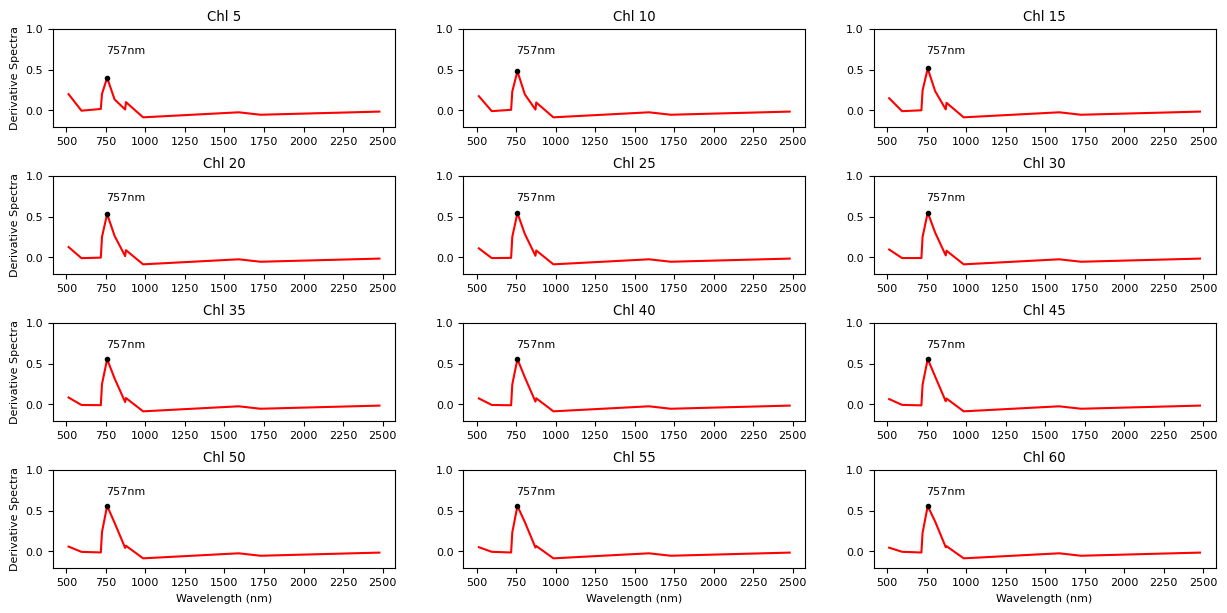

In [30]:
%matplotlib inline

# Parameters for smoothing the spectra. Window size and order of the fitted polynomial
window_len = 5
order = 3

plt.figure(1, figsize=(15, 7))
plt.rcParams.update({"font.size": 8})
plt.subplots_adjust(hspace=0.5)  # increases the space between the two plots
j = 1
for col in tqdm.tqdm(colnames):
    # Smoothing spectra using savitzy-golay algorithm
    spectra_smooth = scipy.signal.savgol_filter(
        s2_chl_refl_data[col], window_len, order
    )

    # Calculate the derivative (gradiant)
    results_spectra[col] = (spectra_smooth[1:] - spectra_smooth[:-1]) / (
        wvls_arr[1:] - wvls_arr[:-1]
    )
    # Find the index of the maximum (highest) derivative
    maxValueIdx = results_spectra[col].idxmax(axis=0)

    plt.subplot(4, 3, j)
    plt.plot(wvl_middle, results_spectra[col].values, "r")
    wvl_abs = results_spectra.at[maxValueIdx, "wvl"]
    plt.plot(wvl_abs, results_spectra[col].max(), ".k")
    plt.text(750, 0.7, str(int(wvl_abs)) + "nm")
    plt.ylim(-0.2, 1)
    plt.title(col)

    if j >= 10:
        plt.xlabel("Wavelength (nm)")
    if (j == 1) or (j == 4) or (j == 7) or (j == 10):
        plt.ylabel("Derivative Spectra")
    j += 1


# Save the results dataframe to a CSV file
results_csv_file = os.path.join(out_s2_chl_dir, "prosail_s2_derivative_spectra_tbl.csv")
results_spectra.to_csv(results_csv_file, index=False)

In [31]:
results_spectra

,Chl 5,Chl 10,Chl 15,Chl 20,Chl 25,Chl 30,Chl 35,Chl 40,Chl 45,Chl 50,Chl 55,Chl 60,wvl
0,0.199221,0.173917,0.149268,0.126827,0.110695,0.096306,0.084435,0.073245,0.065079,0.058653,0.051297,0.045232,513.5
1,-0.003744,-0.009220,-0.009567,-0.009452,-0.008455,-0.008075,-0.007298,-0.006891,-0.005988,-0.005863,-0.005295,-0.004836,595.0
2,0.017590,0.007135,0.001079,-0.002825,-0.005803,-0.008038,-0.009762,-0.010824,-0.011990,-0.013062,-0.013489,-0.013760,717.5
3,0.202085,0.232190,0.244740,0.251239,0.251631,0.251446,0.248742,0.245478,0.241660,0.237246,0.232294,0.228086,725.0
4,0.399032,0.478521,0.513144,0.532183,0.542800,0.549516,0.553663,0.555232,0.556191,0.557158,0.556227,0.555315,757.5
5,0.134549,0.195700,0.235581,0.263799,0.286317,0.303630,0.318410,0.330418,0.341242,0.350612,0.358621,0.365498,804.5
6,0.010996,0.009700,0.012180,0.015403,0.020075,0.024218,0.028800,0.033686,0.037973,0.042452,0.047127,0.051361,871.5
7,0.101296,0.096821,0.092461,0.088717,0.084752,0.081449,0.078137,0.074892,0.072022,0.069168,0.066322,0.063780,876.5
8,-0.085028,-0.085027,-0.085026,-0.085025,-0.085023,-0.085022,-0.085021,-0.085020,-0.085018,-0.085017,-0.085016,-0.085015,985.0
9,-0.023443,-0.023443,-0.023443,-0.023443,-0.023443,-0.023443,-0.023443,-0.023443,-0.023443,-0.023443,-0.023443,-0.023443,1590.0


What do you notice about this result compared to the hyperspectral result? Does it imply that derivative analysis it suitable to apply to multispectral data?

# 8. What have we learnt from this analysis?

We can see from the analysis which has been undertaken that there is sensitivity in both the hyperspectral and multispectral data to chlorophyll. Does that therefore mean that we could map chlorophyll concentration using hyperspectral or multispectral Sentinel-2 imagery?

In simple terms, yes, in controlled conditions with the same vegetation type the variation in reflectance will be related to chlorophyll content. However, the variability in reflectance will also be due to shadowing, variability in the atmosphere not corrected by the atmospheric correction and natural variability in vegetation canopy (e.g., density, cover, height, orientation of the leaves, sun angle). Therefore, in practical terms the ability to resolve chlorophyll content will be limited and would need to be carefully applied. 


## 8.1 How to relate chlorophyll to reflectance?

We’ve seen that the continuum analysis is related to chlorophyll concentration in both the hyperspectral and multispectral data. However, if we wanted to map chlorophyll concentrations, we need to fit a mathematical relationship between either the area or depth from continuum analysis and field measured chlorophyll concentrations. 

Having measured chlorophyll concentrations from field collected samples in the lab, the location of those samples would need to be recorded (i.e., GPS) such that the image pixels related to those samples could be identified and a regression between the two performed. 

Things to consider in undertaking such an analysis:

 * Spatial scale of field samples with respect to the size of the image pixels.
 * Field and spectral samples need to capture the full range values.
 * Be considerate of what other variables might cause changes in the depth and/or area, is chlorophyll the only dependent variable?



# References

Blackburn, G.A., 2006. Hyperspectral remote sensing of plant pigments. J. Exp. Bot. 58, 855–867. https://doi.org/10.1093/jxb/erl123

Punalekar, S., Verhoef, A., Tatarenko, V.I., Van der Tol, C., Macdonald, M.J.D., Marchant, B., Gerard, F., White, K., Gowing, D., 2016. Characterization of a Highly Biodiverse Floodplain Meadow Using Hyperspectral Remote Sensing within a Plant Functional Trait Framework. Remote Sens. 8. https://doi.org/10.3390/rs8020112